# Applied Machine Learning HW6

## Kevin Mueller & Behshad Mohebali


The goal of this assignment is to gain hands on experience with implementing and analyzing annealinng feature selection methods. In particular we implement the Feature Selection with Annealing (FSA) algorithm as described in the class notes. In order to more easily calculate the derivative we make use of the autograd package for python. The features were sucessfully removed by keeping track of an idx array and setting the correct number of parameters to zero at each iteration (to keep them from coming back in gradient).

In [11]:
import os
#import numpy as np
import autograd.numpy as np
import autograd
import warnings
import matplotlib.pyplot as plt
plt.style.use('ggplot')
warnings.filterwarnings("ignore")
import pandas as pd
import autograd
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler

In [12]:


from sklearn.preprocessing import StandardScaler

def lorenz_loss(X,beta,y):
    v = y*(X@beta)
    #out = np.zeros_like(beta)
    c = 1+(v[v<=1]-1)**2
    out = np.log(c)
    
    if np.any(np.isnan(np.mean(out))):
        pdb.set_trace()
    return(np.sum(out)/len(y))


def loss(X,beta,y,s):
    return(lorenz_loss(X,beta,y) + s*np.sum(beta**2))

def inverse_schedule(i,k,M,mu,Niter):
    """calculates total number of features to keep as a function of iteration"""
    l = max(0,(Niter-2*i)/(2*i*mu+Niter))
    #print(l)
    return(int(k+(M-k)*l))


loss_autograd = autograd.grad(loss,1)


In [13]:
def run_fsa(Xtrain,Xtest,ytrain,ytest,k,eta=8e-2,mu=50,s=0.001,Niter=500,print_output=False,print_step=100):
    losses = []
    
    (N,d) = Xtrain.shape
    # Xbar_train = np.hstack([np.ones([N,1]),Xtrain])
    # Xbar_test = np.hstack([np.ones([len(Xtest),1]),Xtest])
    
    
    # standardize data
    scaler = StandardScaler()
    fit_scaler = scaler.fit(Xtrain) #fit scaler on Xtrain
    Xtrain = fit_scaler.transform(Xtrain)
    Xtest = fit_scaler.transform(Xtest)
    
    
    beta0 = np.zeros(d)
    beta = beta0
    Mi = d
    Mi_idx = np.arange(d)
    # #beta0 = np    
    for i in range(500):
        gradL = loss_autograd(Xtrain[:,Mi_idx],beta[Mi_idx],ytrain,s)
        #pdb.set_trace()
        assert(~np.any(np.isnan(gradL)))
        beta[Mi_idx] = beta[Mi_idx] - eta*gradL
        Mi = inverse_schedule(i,k,d,mu,Niter)
        #print(Mi)
        # keep the Mi variables with highest ||B_j||^2
        beta_norm_sqrd = beta**2
        sorted_beta_idx  = np.argsort(beta_norm_sqrd)[::-1]
        Mi_idx = sorted_beta_idx[:Mi]
        beta[sorted_beta_idx[Mi:]] = 1e-10 # to make sure they never come back somehow
        #print(np.linalg.norm(beta))
        ypred = Xtrain[:,Mi_idx]@beta[Mi_idx]
        ypred[ypred<1] = -1
        ypred[ypred>1] = 1
        acc = accuracy_score(ytrain,ypred)
        loss_vals = loss(Xtrain[:,Mi_idx],beta[Mi_idx],ytrain,s)
        losses.append(loss_vals)
        if print_output and i%print_step==0:
            print(Mi,acc,loss(Xtrain[:,Mi_idx],beta[Mi_idx],ytrain,s))
    
    ypred = Xtrain[:,Mi_idx]@beta[Mi_idx]
    ypred[ypred<1] = -1
    ypred[ypred>1] = 1
    #loss_vals = loss(Xtrain[:,Mi_idx],beta[Mi_idx],ytrain,s)
    train_acc = accuracy_score(ytrain,ypred)

    ypred = Xtest[:,Mi_idx]@beta[Mi_idx]
    ypred[ypred<1] = -1
    ypred[ypred>1] = 1
    test_acc = accuracy_score(ytest,ypred)
    #loss_vals = loss(Xtrain[:,Mi_idx],beta[Mi_idx],ytrain,s
    

    return(beta,losses,train_acc,test_acc)

In [14]:
def run_fsa_loop(train_data,train_labels,valid_data,valid_labels,ks = [10,30,100,300,500],eta=1e-2):
    losses_k = []
    train_acc_k =[]
    test_acc_k =[]
    for k in ks:
        print("k: {}".format(k))
        beta_opt,losses,train_acc,test_acc = run_fsa(train_data,
                                                     valid_data,
                                                     train_labels,
                                                     valid_labels,k=k,eta=1e-2,print_output=True)
        losses_k.append(losses)
        train_acc_k.append(train_acc)
        test_acc_k.append(test_acc)
        print("test accuracy: {}".format(test_acc))
        
    return(losses_k,np.array(train_acc_k),np.array(test_acc_k))


# Gissette

In [15]:

def read_labels(madelon_labels_path):
    labels = open(madelon_labels_path,'r').read()
    labels = np.array([_ for _ in labels.split("\n") if _ != ''],np.float)
    labels[labels==-1]=-1 # can convert to binary but not necessary
    return(labels)

def read_dataset(madelon_data_path):
    df = pd.read_csv(madelon_data_path,delimiter=" ",header=None)
    df = df.iloc[:,:-1] # need to remove last column 
    return(df.values)

root_dataset_dir = os.path.join(os.getcwd(),"Applied Machine Learning- DataSets")

gisette_train_labels = read_labels(os.path.join(root_dataset_dir,'gisette',"gisette_train.labels"))
gisette_train_data = read_dataset(os.path.join(root_dataset_dir,'gisette',"gisette_train.data"))
gisette_valid_labels = read_labels(os.path.join(root_dataset_dir,'gisette',"gisette_valid.labels"))
gisette_valid_data = read_dataset(os.path.join(root_dataset_dir,'gisette',"gisette_valid.data"))
print(gisette_train_data.shape)

(6000, 5000)


In [16]:

gissette_losses_k,gissette_train_acc_k,gissette_test_acc_k = run_fsa_loop(gisette_train_data,
                                                                     gisette_train_labels,
                                                                     gisette_valid_data,
                                                                     gisette_valid_labels)
                                                        


k: 10
5000 0.5385 0.2857819144586046
152 0.8083333333333333 0.08123218165609779
34 0.722 0.13557059216065226
10 0.7916666666666666 0.20522231101963162
10 0.8065 0.19481357272729133
test accuracy: 0.798
k: 30
5000 0.5385 0.2857819144586046
172 0.812 0.07547664342041364
54 0.7483333333333333 0.1057190110107374
30 0.8005 0.1112383197543814
30 0.8521666666666666 0.09917671113356696
test accuracy: 0.864
k: 100
5000 0.5385 0.2857819144586046
240 0.849 0.06341699059487993
123 0.8478333333333333 0.0639309260506373
100 0.8775 0.05712964957511118
100 0.8998333333333334 0.05018284413411855
test accuracy: 0.914
k: 300
5000 0.5385 0.2857819144586046
434 0.88 0.04807469119051939
322 0.8996666666666666 0.039231528123996814
300 0.9213333333333333 0.03360180232526247
300 0.933 0.030375782296827462
test accuracy: 0.942
k: 500
5000 0.5385 0.2857819144586046
628 0.8938333333333334 0.04181905851804581
521 0.9155 0.03229310005501885
500 0.9326666666666666 0.02741661779664637
500 0.9406666666666667 0.0245233

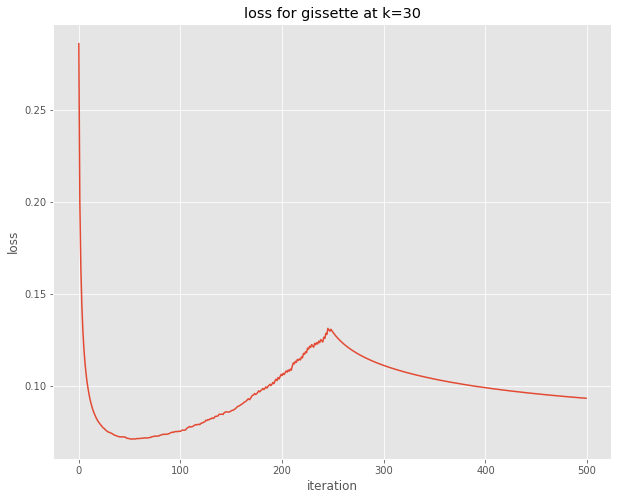

In [27]:
plt.figure(figsize=(10,8))
plt.title("loss for {} at k=30".format('gissette'))
plt.plot(np.arange(500),gissette_losses_k[1])    
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

# Dexter

In [18]:
def read_data_file(fp ='dexter/dexter_train.data'):
    f = open(os.path.join(root_dataset_dir,fp),'r')
    data = f.readlines()
    f.close()
    vals,idxs = [],[]
    out = np.zeros([300,20000])
    for (i,line) in enumerate(data):
        spltline = line.split(' ')
        idxs=[int(_.split(':')[0]) for _ in spltline[:-1]]
        vals=[int(_.split(':')[1]) for _ in spltline[:-1]]
        out[i,idxs] = vals    
    return(out)

In [19]:
Xtrain = read_data_file('dexter/dexter_train.data')
Xtest = read_data_file('dexter/dexter_valid.data')
ytrain = read_labels(os.path.join(root_dataset_dir,'dexter/dexter_train.labels'))
ytest = read_labels(os.path.join(root_dataset_dir,'dexter/dexter_valid.labels'))

In [20]:

dexter_losses_k,dexter_train_acc_k,dexter_test_acc_k = run_fsa_loop(Xtrain,
                                                                     ytrain,
                                                                     Xtest,
                                                                     ytest)
                     

k: 10
20000 0.5 0.36665458377775134
581 0.7033333333333334 0.00577105435957507
107 0.65 0.06523500623704434
10 0.5766666666666667 0.304185551188558
10 0.64 0.250693422707258
test accuracy: 0.6566666666666666
k: 30
20000 0.5 0.36665458377775134
600 0.6866666666666666 0.004825394121979835
127 0.6633333333333333 0.04799962832633108
30 0.68 0.1556588569678533
30 0.77 0.12102615910888997
test accuracy: 0.7566666666666667
k: 100
20000 0.5 0.36665458377775134
668 0.7033333333333334 0.004121162035394921
197 0.7166666666666667 0.0195748099731454
100 0.8266666666666667 0.02151586674317271
100 0.8966666666666666 0.009808194475763487
test accuracy: 0.7366666666666667
k: 300
20000 0.5 0.36665458377775134
862 0.73 0.002289372809420351
396 0.7933333333333333 0.0032440384911218874
300 0.9 0.000777398662603802
300 0.94 0.00028391566432907665
test accuracy: 0.6333333333333333
k: 500
20000 0.5 0.36665458377775134
1057 0.7933333333333333 0.0018871071769038918
595 0.8166666666666667 0.0009069490715291119
5

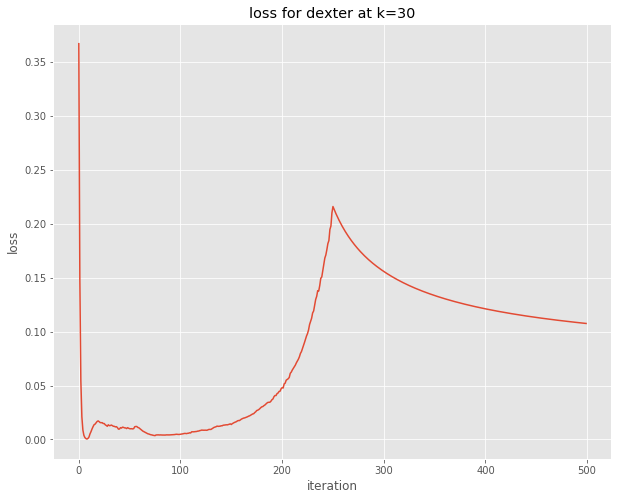

In [21]:
plt.figure(figsize=(10,8))
plt.title("loss for {} at k=30".format('dexter'))
plt.plot(np.arange(500),dexter_losses_k[1])    
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

# Madelon

In [22]:
madelon_train_labels = read_labels(os.path.join(root_dataset_dir,'MADELON',"madelon_train.labels"))
madelon_train_data = read_dataset(os.path.join(root_dataset_dir,'MADELON',"madelon_train.data"))
madelon_valid_labels = read_labels(os.path.join(root_dataset_dir,'MADELON',"madelon_valid.labels"))
madelon_valid_data = read_dataset(os.path.join(root_dataset_dir,'MADELON',"madelon_valid.data"))   

In [23]:

madelon_losses_k,madelon_train_acc_k,madelon_test_acc_k = run_fsa_loop(madelon_train_data,
                                                                         madelon_train_labels,
                                                                         madelon_valid_data,
                                                                         madelon_valid_labels)

k: 10
500 0.5 0.6879511597758315
24 0.516 0.5842953919686297
12 0.5105 0.5862077182641952
10 0.513 0.5865424020137774
10 0.5155 0.5856571313986509
test accuracy: 0.52
k: 30
500 0.5 0.6879511597758315
43 0.5215 0.5662404381632483
32 0.5155 0.5566422311785477
30 0.526 0.5543497176221173
30 0.531 0.5523232903490914
test accuracy: 0.5216666666666666
k: 100
500 0.5 0.6879511597758315
111 0.5275 0.5256405893288679
101 0.5365 0.5035984982382562
100 0.551 0.49567121942995335
100 0.557 0.49254945148735274
test accuracy: 0.545
k: 300
500 0.5 0.6879511597758315
305 0.5295 0.48870728200160285
300 0.5545 0.4559847591339298
300 0.571 0.4436666399801984
300 0.581 0.4376768521816826
test accuracy: 0.5633333333333334
k: 500
500 0.5 0.6879511597758315
500 0.5255 0.48008760410475626
500 0.552 0.443548451452284
500 0.563 0.42772169569789303
500 0.569 0.41901257173426837
test accuracy: 0.5583333333333333


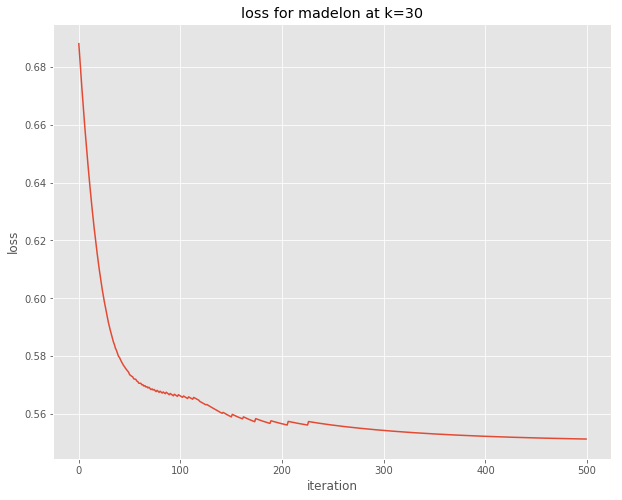

In [24]:
plt.figure(figsize=(10,8))
plt.title("loss for {} at k=30".format('madelon'))
plt.plot(np.arange(500),madelon_losses_k[1])    
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

# Error Table/Plots

In [28]:
import pandas as pd
ks = [10,30,100,300,500]
df_accs = pd.DataFrame({"train error (Gissette)":1-gissette_train_acc_k,
                        "test error (Gissete)":1-gissette_test_acc_k,
                        "train error (Dexter)":1-dexter_train_acc_k,
                        "test error (Dexter)":1-dexter_test_acc_k,
                       "train error (Madelon)":1-madelon_train_acc_k,
                        "test error (Madelon)":1-madelon_test_acc_k})
df_accs.index = ks
df_accs

,train error (Gissette),test error (Gissete),train error (Dexter),test error (Dexter),train error (Madelon),test error (Madelon)
10,0.182333,0.202,0.320000,0.343333,0.4855,0.480000
30,0.131667,0.136,0.183333,0.243333,0.4680,0.478333
100,0.090333,0.086,0.076667,0.263333,0.4410,0.455000
300,0.060000,0.058,0.043333,0.366667,0.4120,0.436667
500,0.054167,0.060,0.053333,0.420000,0.4260,0.441667


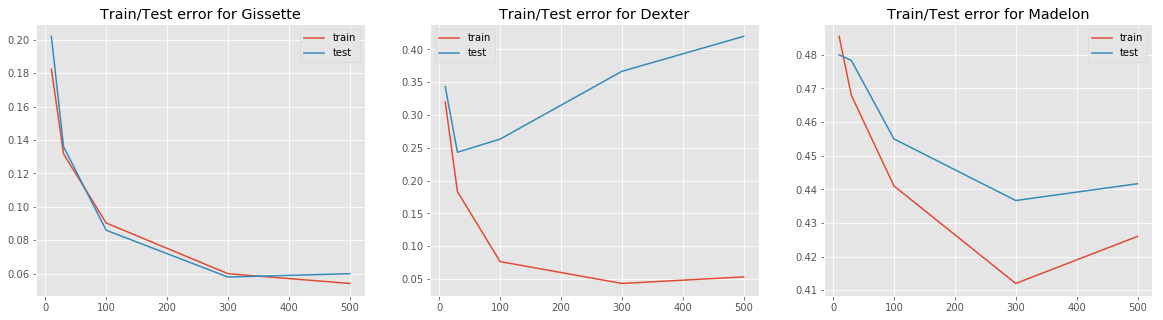

In [34]:
Niter = 500
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.title("Train/Test error for Gissette")
plt.plot(ks,1-gissette_train_acc_k,label='train')
plt.plot(ks,1-gissette_test_acc_k,label='test')
plt.legend()
plt.subplot(132)
plt.title("Train/Test error for Dexter")
plt.plot(ks,1-dexter_train_acc_k,label='train')
plt.plot(ks,1-dexter_test_acc_k,label='test')
plt.legend()
plt.subplot(133)
plt.title("Train/Test error for Madelon")
plt.plot(ks,1-madelon_train_acc_k,label='train')
plt.plot(ks,1-madelon_test_acc_k,label='test')
plt.legend()
plt.show()
